In [20]:
from google.colab import drive

In [21]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import keras
from tensorflow.keras.layers import MaxPooling2D, Conv2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda
from keras.activations import sigmoid
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras import initializers
from keras.models import Sequential

In [23]:
#train path
train_p = "/content/drive/MyDrive/Alzheimer_s Dataset/train"
#test path
test_p = "/content/drive/MyDrive/Alzheimer_s Dataset/test"

In [24]:
train_datagen = ImageDataGenerator(validation_split=0.1,
                                   rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

In [25]:
train_batches = train_datagen.flow_from_directory(directory="/content/drive/MyDrive/Alzheimer_s Dataset/train", 
                                                  classes=['NonDemented', 'VeryMildDemented', 
                                                           'MildDemented', 'ModerateDemented'], 
                                                  target_size=(224, 224),
                                                  subset='training', 
                                                  batch_size=10)

Found 4610 images belonging to 4 classes.


In [26]:
validation_batches = train_datagen.flow_from_directory(directory="/content/drive/MyDrive/Alzheimer_s Dataset/train", 
                                                       classes=['NonDemented', 'VeryMildDemented', 
                                                                'MildDemented', 'ModerateDemented'], 
                                                       target_size=(224, 224),
                                                       subset='validation',
                                                       batch_size=10)

Found 511 images belonging to 4 classes.


In [27]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [28]:
test_batches = test_datagen.flow_from_directory(directory="/content/drive/MyDrive/Alzheimer_s Dataset/test", 
                                                classes=['NonDemented', 'VeryMildDemented', 
                                                         'MildDemented', 'ModerateDemented'], 
                                                target_size=(224, 224),
                                                batch_size=10, 
                                                shuffle=False)
     

Found 1279 images belonging to 4 classes.


In [29]:
class_names = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
num_images = []
import os
for cls in class_names:
    path = os.path.join(train_p, cls)
    num_images.append(len(os.listdir("/content/drive/MyDrive/Alzheimer_s Dataset/train")))
     


In [30]:
from matplotlib import pyplot as plt

Text(0, 0.5, 'Number of Images')

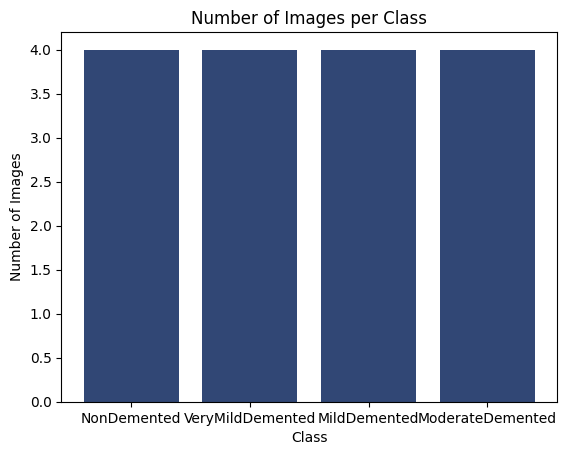

In [31]:
fig, ax = plt.subplots()
ax.bar(class_names, num_images, color=(0.1, 0.2, 0.4, 0.9))
ax.set_title('Number of Images per Class')
ax.set_xlabel('Class')
ax.set_ylabel('Number of Images')

In [32]:
img_size = 224
num_classes = 4
model = Sequential([
    layers.Input((img_size, img_size, 3)),
    layers.Rescaling(1./255),
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2),
    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2),
    layers.Conv2D(128, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2),
    layers.Conv2D(256, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2),
    layers.Flatten(),
    layers.Dense(300, activation='relu'),
    layers.Dense(150, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(num_classes, activation='softmax')
])


In [33]:
metrics = [keras.metrics.CategoricalAccuracy(name='accuracy'),
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall'),
           keras.metrics.AUC(name='auc')]
     

In [45]:
import tensorflow as tf
import keras

In [46]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=metrics)

In [36]:
epo = 3
b_size = 8

In [37]:
history = model.fit(x=train_batches,
                    validation_data=validation_batches,
                    steps_per_epoch=len(train_batches),
                    validation_steps=len(validation_batches),
                    epochs=epo,
                    batch_size=b_size, 
                    verbose=2)

Epoch 1/3
461/461 - 1821s - loss: 1.2344 - accuracy: 0.4798 - precision: 0.5245 - recall: 0.3759 - auc: 0.7710 - val_loss: 6.3984 - val_accuracy: 0.0098 - val_precision: 0.0098 - val_recall: 0.0098 - val_auc: 0.4399 - 1821s/epoch - 4s/step
Epoch 2/3
461/461 - 1053s - loss: 0.9977 - accuracy: 0.5289 - precision: 0.6062 - recall: 0.3633 - auc: 0.8134 - val_loss: 1.0294 - val_accuracy: 0.5479 - val_precision: 0.6367 - val_recall: 0.3875 - val_auc: 0.8172 - 1053s/epoch - 2s/step
Epoch 3/3
461/461 - 1065s - loss: 0.9675 - accuracy: 0.5304 - precision: 0.6238 - recall: 0.3575 - auc: 0.8220 - val_loss: 0.9498 - val_accuracy: 0.5499 - val_precision: 0.7448 - val_recall: 0.2798 - val_auc: 0.8206 - 1065s/epoch - 2s/step


In [38]:
import cv2
import matplotlib.pyplot as plt

In [39]:
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName

        if self.layerName is None:
            self.layerName = self.find_target_layer()
            
    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            if len(layer.output_shape) == 4:
                return layer.name
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
        
    def compute_heatmap(self, image, eps=1e-8):

        gradModel = tf.keras.Model(
        inputs=[self.model.inputs],
        outputs=[self.model.get_layer(self.layerName).output,
                 self.model.output])
      
        with tf.GradientTape() as tape:

            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
        

        grads = tape.gradient(loss, convOutputs)

        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        
      
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]
        

        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
    
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")

        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
        colormap=cv2.COLORMAP_VIRIDIS):

        heatmap = cv2.applyColorMap(heatmap, colormap)
        image = np.asarray(image, np.float64)
        heatmap = np.asarray(heatmap, np.float64)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)

        return (heatmap, output)

In [40]:
def show_heatmap(model, img_path):
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    preds = model.predict(image)
    i = np.argmax(preds[0])
    label_to_class = {'NonDemented': 0,
                      'VeryMildDemented': 1,
                      'MildDemented': 2,
                      'ModerateDemented': 3}

    class_to_label = {v: k for k, v in label_to_class.items()}

    label = class_to_label[i]
    print(f'Predicted class: {label} | Prediction probability: {max(preds[0]) * 100}%')
    
    cam = GradCAM(model, i)
    heatmap = cam.compute_heatmap(image)

    (heatmap, output) = cam.overlay_heatmap(heatmap, image[0], alpha=0.5)
    
    output = output.astype(np.uint8)
    plt.imshow(output, interpolation='nearest')
    plt.show()

In [41]:
from tensorflow.keras.preprocessing.image import load_img

In [42]:
from tensorflow.keras.preprocessing.image import img_to_array

In [43]:
from tensorflow.keras import models

In [48]:
import numpy as np

1/1 [==============================] - 0s 238ms/step
Predicted class: VeryMildDemented | Prediction probability: 100.0%


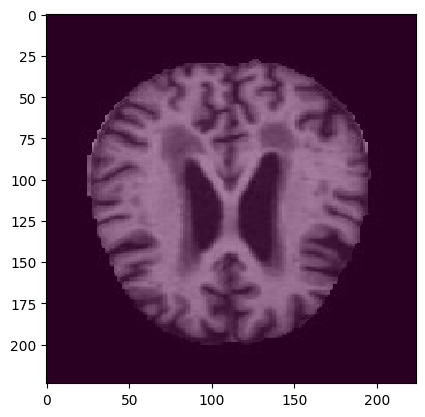

In [49]:
img_path = "/content/drive/MyDrive/Alzheimer_s Dataset/test/MildDemented/31 (22).jpg"
show_heatmap(model, img_path)

1/1 [==============================] - 0s 75ms/step
Predicted class: NonDemented | Prediction probability: 100.0%


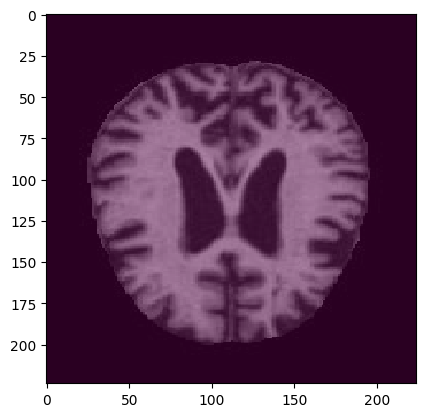

In [52]:
img_path ="/content/drive/MyDrive/Alzheimer_s Dataset/test/ModerateDemented/32 (2).jpg" 
show_heatmap(model, img_path)

1/1 [==============================] - 0s 75ms/step
Predicted class: VeryMildDemented | Prediction probability: 100.0%


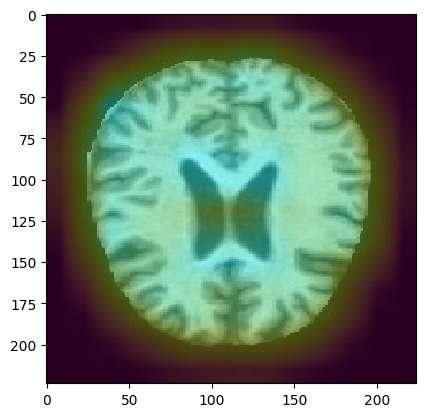

In [53]:
img_path ="/content/drive/MyDrive/Alzheimer_s Dataset/test/NonDemented/28 (42).jpg"
show_heatmap(model, img_path)

1/1 [==============================] - 0s 123ms/step
Predicted class: VeryMildDemented | Prediction probability: 100.0%


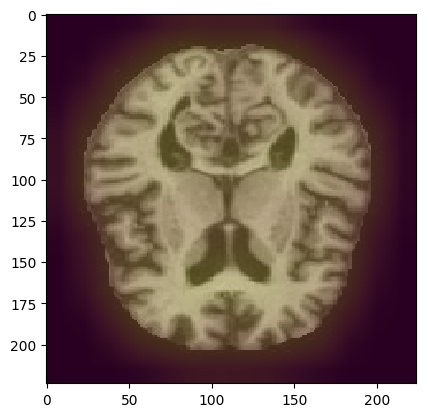

In [54]:
img_path ="/content/drive/MyDrive/Alzheimer_s Dataset/train/MildDemented/mildDem258.jpg"
show_heatmap(model, img_path)